# **Library and Module Imports**

In [2]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
import pandas as pd
import re
import numpy as np 
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import os

c:\Users\Asus\anaconda3\envs\my_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **NLTK Module**

In [5]:
import nltk

# Set the NLTK data path
nltk.data.path.append('assets/nltk_data')

nltk.download('stopwords', download_dir='assets/nltk_data')
nltk.download('punkt', download_dir='assets/nltk_data')
nltk.download('punkt_tab', download_dir='assets/nltk_data')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to assets/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to assets/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to assets/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [6]:
# **Load Data**

In [9]:
# Load the existing dataset
df_orginal = pd.read_csv('text-emotion-dataset.csv')

# Function to clean the text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove non-alphanumeric characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'\&\w+;', '', text)  # Remove HTML entities
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Apply text cleaning
df_orginal['text'] = df_orginal['text'].apply(clean_text)
df = df_orginal.rename(columns={'label': 'emotion'})

df

,text,emotion
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


In [ ]:
# Remove stop words (requires nltk)
stop_words = set(stopwords.words('english'))
def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

df['text'] = df['text'].apply(remove_stop_words)

In [11]:
df['text'] = df['text'].apply(remove_stop_words)

df

,text,emotion
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4
...,...,...
416804,feel like telling horny devils find site suite...,2
416805,began realize feeling agitated restless would ...,3
416806,feel curious previous early dawn time seek tro...,5
416807,feel becuase tyranical nature government el sa...,3


In [12]:
print(df.isnull().sum())  # Check if there are any missing values

text       0
emotion    0
dtype: int64


In [13]:
emotion_counts = df['emotion'].value_counts()
print("Emotion Counts:")
print(emotion_counts)

Emotion Counts:
emotion
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


In [15]:
import pandas as pd

final_df = df.groupby('emotion', group_keys=False).head(7500)

# Verify the result
print(final_df['emotion'].value_counts())

emotion
4    7500
0    7500
2    7500
1    7500
5    7500
3    7500
Name: count, dtype: int64


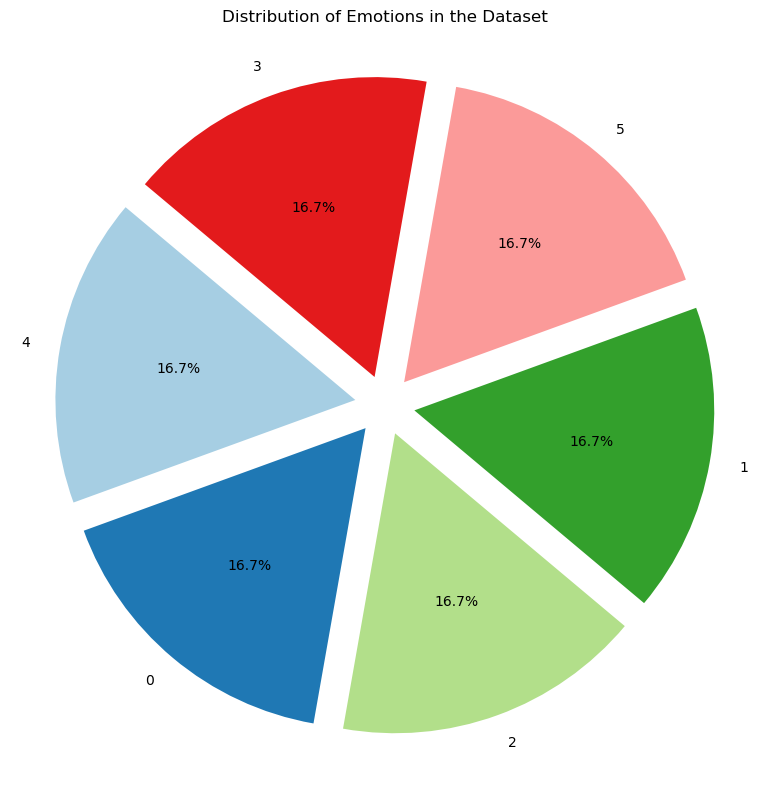

In [16]:
import matplotlib.pyplot as plt

# Get the distribution of emotions
emotion_counts = final_df['emotion'].value_counts()

# Define the explode settings for breaking slices
# Exploding every slice
explode = [0.1] * len(emotion_counts)  # Explodes all slices

# Define the color palette for the pie chart
colors = plt.cm.Paired(range(len(emotion_counts)))

# Create a pie chart with shadow effect
plt.figure(figsize=(8, 8))
plt.pie(
    emotion_counts,
    labels=emotion_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,  # Explode the slices
    # shadow=True,      # Adds shadow effect
    colors=colors     # Use the defined colors
)

# Set the title and other labels
plt.title('Distribution of Emotions in the Dataset')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# **RoBERTa Tokenize and Encode the Text**

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset


roberta_model_save_path = 'roberta/model'
roberta_tokenizer_save_path = 'roberta/tokenizer'
roberta_output_dir = 'roberta/output_dir'
roberta_logging_dir = 'roberta/logging_dir'
roberta_test_results = 'roberta/test_results'

model_name = "roberta-base"
df_combined = final_df[['text', 'emotion']]

# # Load the BERT tokenizer
if os.path.exists(roberta_tokenizer_save_path):
    tokenizer = RobertaTokenizer.from_pretrained(roberta_model_save_path)
else:
    tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Tokenize the dataset
def tokenize_function(examples):
    # Tokenize the text and also add attention_mask
    encoding = tokenizer(examples['text'], padding=True, truncation=True, max_length=256)
    encoding['labels'] = examples['emotion']  # Add the label as 'labels'
    return encoding

# Convert the DataFrame to a HuggingFace Dataset
dataset = Dataset.from_pandas(df_combined)

# # Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# # Check if tokenization was successful
print(tokenized_datasets[0])

Map: 100%|██████████| 45000/45000 [00:04<00:00, 9950.17 examples/s] 

{'text': 'feel really helpless heavy hearted', 'emotion': 4, '__index_level_0__': 0, 'input_ids': [0, 35702, 269, 22445, 2016, 1144, 196, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 4}


# **Split the Dataset into Train and Test Sets**

In [18]:
# Split the dataset into training and testing sets
train_dataset, test_dataset = tokenized_datasets.train_test_split(test_size=0.2, seed=42).values()

# **Load the RoBERTa Model**

In [19]:
# Load the pre-trained RoBERTa model
num_labels = len(df_combined['emotion'].unique())
roberta_model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **RoBERTa Training Setup**

In [22]:
from transformers import DataCollatorWithPadding, RobertaTokenizer, RobertaForSequenceClassification
def train_roberta():
    training_args = TrainingArguments(
      output_dir=roberta_output_dir,
      num_train_epochs=5,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      warmup_steps=500,
      weight_decay=0.01,
      logging_dir=roberta_logging_dir,
      logging_steps=50,
      evaluation_strategy="epoch",
      save_strategy="epoch",
      learning_rate=2e-5,
      fp16=True,
      gradient_accumulation_steps=4,
      load_best_model_at_end=True,
      save_total_limit=3,
  )


    # Use DataCollatorWithPadding to handle padding dynamically
    data_collator = DataCollatorWithPadding(tokenizer)


    # Initialize the Trainer with model, training args, and the datasets
    roberta_trainer = Trainer(
        model=roberta_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        data_collator=data_collator,
    )

    roberta_trainer.train()

    # Save the model and tokenizer
    roberta_model.save_pretrained(roberta_model_save_path)
    tokenizer.save_pretrained(roberta_tokenizer_save_path)
    return roberta_trainer


# Check if the model exists and load or train
if os.path.exists(roberta_model_save_path) and os.path.exists(roberta_tokenizer_save_path):
    print(f"Loading pre-trained model and tokenizer from {roberta_model_save_path}")
    roberta_model = RobertaForSequenceClassification.from_pretrained(roberta_model_save_path)
    tokenizer = RobertaTokenizer.from_pretrained(roberta_tokenizer_save_path)
    print(f"Model loaded from {roberta_model_save_path}")
    print(f"Tokenizer loaded from {roberta_tokenizer_save_path}")
    # Create a trainer object and evaluate the model
    roberta_trainer = Trainer(
        model=roberta_model,
        args=TrainingArguments(output_dir=roberta_output_dir),
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        data_collator=DataCollatorWithPadding(tokenizer)
    )
    # print("Evaluating pre-trained model...")
    # bert_results = bert_trainer.evaluate()
    # print(bert_results)

else:
    print("Training model...")
    roberta_trainer = train_roberta()  # Train and get the trainer object
    print("Model training complete.")

Training model...


  4%|▍         | 126/2810 [01:36<34:14,  1.31it/s]
                                                 
  2%|▏         | 50/2810 [00:19<17:11,  2.68it/s] 

{'loss': 1.287, 'grad_norm': 7.692534923553467, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.09}


                                                  
  4%|▎         | 100/2810 [00:38<17:07,  2.64it/s]

{'loss': 1.1246, 'grad_norm': 8.188759803771973, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.18}


                                                  
  5%|▌         | 150/2810 [00:57<17:06,  2.59it/s]

{'loss': 0.9142, 'grad_norm': 11.550250053405762, 'learning_rate': 5.9600000000000005e-06, 'epoch': 0.27}


                                                  
  7%|▋         | 200/2810 [01:15<16:19,  2.66it/s]

{'loss': 0.7202, 'grad_norm': 10.233942985534668, 'learning_rate': 7.960000000000002e-06, 'epoch': 0.36}


                                                  
  9%|▉         | 250/2810 [01:34<16:01,  2.66it/s]

{'loss': 0.5576, 'grad_norm': 11.565651893615723, 'learning_rate': 9.960000000000001e-06, 'epoch': 0.44}


                                                  
 11%|█         | 300/2810 [01:53<15:33,  2.69it/s]

{'loss': 0.4215, 'grad_norm': 16.658164978027344, 'learning_rate': 1.196e-05, 'epoch': 0.53}


                                                  
 12%|█▏        | 350/2810 [02:12<15:16,  2.68it/s]

{'loss': 0.3578, 'grad_norm': 5.030728816986084, 'learning_rate': 1.3880000000000001e-05, 'epoch': 0.62}


                                                  
 14%|█▍        | 400/2810 [02:30<15:24,  2.61it/s]

{'loss': 0.2817, 'grad_norm': 5.961597919464111, 'learning_rate': 1.588e-05, 'epoch': 0.71}


                                                  
 16%|█▌        | 450/2810 [02:50<15:27,  2.54it/s]

{'loss': 0.2768, 'grad_norm': 10.900167465209961, 'learning_rate': 1.788e-05, 'epoch': 0.8}


                                                  
 18%|█▊        | 500/2810 [03:09<14:24,  2.67it/s]

{'loss': 0.2664, 'grad_norm': 13.94238567352295, 'learning_rate': 1.9880000000000003e-05, 'epoch': 0.89}


                                                  
 20%|█▉        | 550/2810 [03:28<14:18,  2.63it/s]

{'loss': 0.2294, 'grad_norm': 10.59444522857666, 'learning_rate': 1.9593073593073594e-05, 'epoch': 0.98}


 20%|██        | 562/2810 [03:32<14:08,  2.65it/s]























































































































                                                  
                                               

 20%|██        | 562/2810 [03:46<14:08,  2.65it/s]



{'eval_loss': 0.21143516898155212, 'eval_runtime': 14.118, 'eval_samples_per_second': 637.485, 'eval_steps_per_second': 39.878, 'epoch': 1.0}


                                                    
 21%|██▏       | 600/2810 [04:03<13:50,  2.66it/s]

{'loss': 0.195, 'grad_norm': 9.22835636138916, 'learning_rate': 1.916017316017316e-05, 'epoch': 1.07}


                                                  
 23%|██▎       | 650/2810 [04:22<13:45,  2.62it/s]

{'loss': 0.2127, 'grad_norm': 17.081884384155273, 'learning_rate': 1.872727272727273e-05, 'epoch': 1.16}


                                                  
 25%|██▍       | 700/2810 [04:41<13:46,  2.55it/s]

{'loss': 0.1791, 'grad_norm': 3.5224545001983643, 'learning_rate': 1.8294372294372297e-05, 'epoch': 1.24}


                                                  
 27%|██▋       | 750/2810 [05:00<13:06,  2.62it/s]

{'loss': 0.1918, 'grad_norm': 25.021888732910156, 'learning_rate': 1.7861471861471863e-05, 'epoch': 1.33}


                                                  
 28%|██▊       | 800/2810 [05:19<12:57,  2.59it/s]

{'loss': 0.179, 'grad_norm': 2.390498638153076, 'learning_rate': 1.742857142857143e-05, 'epoch': 1.42}


                                                  
 30%|███       | 850/2810 [05:39<12:10,  2.68it/s]

{'loss': 0.1715, 'grad_norm': 18.25311279296875, 'learning_rate': 1.6995670995670995e-05, 'epoch': 1.51}


                                                  
 32%|███▏      | 900/2810 [05:58<12:13,  2.60it/s]

{'loss': 0.1755, 'grad_norm': 4.173163890838623, 'learning_rate': 1.6562770562770565e-05, 'epoch': 1.6}


                                                  
 34%|███▍      | 950/2810 [06:17<11:27,  2.70it/s]

{'loss': 0.1734, 'grad_norm': 5.798824310302734, 'learning_rate': 1.612987012987013e-05, 'epoch': 1.69}


                                                   
 36%|███▌      | 1000/2810 [06:36<11:26,  2.64it/s]

{'loss': 0.1587, 'grad_norm': 4.444473743438721, 'learning_rate': 1.5696969696969698e-05, 'epoch': 1.78}


                                                   
 37%|███▋      | 1050/2810 [06:56<11:23,  2.58it/s]

{'loss': 0.1579, 'grad_norm': 16.07048797607422, 'learning_rate': 1.5264069264069264e-05, 'epoch': 1.87}


                                                   
 39%|███▉      | 1100/2810 [07:15<10:44,  2.66it/s]

{'loss': 0.1488, 'grad_norm': 1.3887827396392822, 'learning_rate': 1.4831168831168832e-05, 'epoch': 1.96}


 40%|████      | 1125/2810 [07:24<10:35,  2.65it/s]


















































































































                                                   

                                           
 40%|████      | 1125/2810 [07:38<10:35,  2.65it/s]



{'eval_loss': 0.1399260014295578, 'eval_runtime': 13.8998, 'eval_samples_per_second': 647.491, 'eval_steps_per_second': 40.504, 'epoch': 2.0}


                                                     
 41%|████      | 1150/2810 [07:50<10:33,  2.62it/s]

{'loss': 0.1466, 'grad_norm': 24.069814682006836, 'learning_rate': 1.43982683982684e-05, 'epoch': 2.04}


                                                   
 43%|████▎     | 1200/2810 [08:10<10:08,  2.65it/s]

{'loss': 0.1409, 'grad_norm': 6.524266242980957, 'learning_rate': 1.3965367965367966e-05, 'epoch': 2.13}


                                                   
 44%|████▍     | 1250/2810 [08:29<10:08,  2.56it/s]

{'loss': 0.1409, 'grad_norm': 4.335350513458252, 'learning_rate': 1.3532467532467533e-05, 'epoch': 2.22}


                                                   
 46%|████▋     | 1300/2810 [08:48<10:01,  2.51it/s]

{'loss': 0.1444, 'grad_norm': 4.620229244232178, 'learning_rate': 1.30995670995671e-05, 'epoch': 2.31}


                                                   
 48%|████▊     | 1350/2810 [09:08<09:11,  2.65it/s]

{'loss': 0.1259, 'grad_norm': 5.530267238616943, 'learning_rate': 1.2666666666666667e-05, 'epoch': 2.4}


                                                   
 50%|████▉     | 1400/2810 [09:27<09:29,  2.48it/s]

{'loss': 0.1281, 'grad_norm': 4.409774303436279, 'learning_rate': 1.2233766233766235e-05, 'epoch': 2.49}


                                                   
 52%|█████▏    | 1450/2810 [09:47<08:37,  2.63it/s]

{'loss': 0.1222, 'grad_norm': 1.6248987913131714, 'learning_rate': 1.1800865800865801e-05, 'epoch': 2.58}


                                                   
 53%|█████▎    | 1500/2810 [10:06<08:21,  2.61it/s]

{'loss': 0.1235, 'grad_norm': 5.938638687133789, 'learning_rate': 1.1367965367965367e-05, 'epoch': 2.67}


                                                   
 55%|█████▌    | 1550/2810 [10:26<08:07,  2.58it/s]

{'loss': 0.124, 'grad_norm': 3.320214033126831, 'learning_rate': 1.0935064935064937e-05, 'epoch': 2.76}


                                                   
 57%|█████▋    | 1600/2810 [10:45<07:40,  2.63it/s]

{'loss': 0.1275, 'grad_norm': 1.4759573936462402, 'learning_rate': 1.0502164502164502e-05, 'epoch': 2.84}


                                                   
 59%|█████▊    | 1650/2810 [11:04<07:32,  2.56it/s]

{'loss': 0.1282, 'grad_norm': 2.782374382019043, 'learning_rate': 1.0069264069264071e-05, 'epoch': 2.93}


 60%|██████    | 1687/2810 [11:19<07:07,  2.63it/s]
































































































































                                                   

                                           
 60%|██████    | 1687/2810 [11:34<07:07,  2.63it/s]



{'eval_loss': 0.12598995864391327, 'eval_runtime': 15.1906, 'eval_samples_per_second': 592.473, 'eval_steps_per_second': 37.063, 'epoch': 3.0}


                                                     
 60%|██████    | 1700/2810 [11:42<08:24,  2.20it/s]

{'loss': 0.1155, 'grad_norm': 24.202327728271484, 'learning_rate': 9.636363636363638e-06, 'epoch': 3.02}


                                                   
 62%|██████▏   | 1750/2810 [12:01<06:45,  2.62it/s]

{'loss': 0.1004, 'grad_norm': 1.5512117147445679, 'learning_rate': 9.203463203463204e-06, 'epoch': 3.11}


                                                   
 64%|██████▍   | 1800/2810 [12:20<06:34,  2.56it/s]

{'loss': 0.1145, 'grad_norm': 2.007249116897583, 'learning_rate': 8.770562770562772e-06, 'epoch': 3.2}


                                                   
 66%|██████▌   | 1850/2810 [12:40<06:15,  2.56it/s]

{'loss': 0.109, 'grad_norm': 5.368345260620117, 'learning_rate': 8.337662337662338e-06, 'epoch': 3.29}


                                                   
 68%|██████▊   | 1900/2810 [12:59<05:49,  2.60it/s]

{'loss': 0.1109, 'grad_norm': 6.523758888244629, 'learning_rate': 7.904761904761904e-06, 'epoch': 3.38}


                                                   
 69%|██████▉   | 1950/2810 [13:19<05:45,  2.49it/s]

{'loss': 0.1058, 'grad_norm': 2.6938869953155518, 'learning_rate': 7.471861471861472e-06, 'epoch': 3.47}


                                                   
 71%|███████   | 2000/2810 [13:38<05:07,  2.64it/s]

{'loss': 0.1025, 'grad_norm': 2.727642297744751, 'learning_rate': 7.0389610389610395e-06, 'epoch': 3.56}


                                                   
 73%|███████▎  | 2050/2810 [13:57<04:59,  2.54it/s]

{'loss': 0.1212, 'grad_norm': 1.237192988395691, 'learning_rate': 6.606060606060607e-06, 'epoch': 3.64}


                                                   
 75%|███████▍  | 2100/2810 [14:16<04:31,  2.62it/s]

{'loss': 0.1053, 'grad_norm': 3.1592321395874023, 'learning_rate': 6.173160173160173e-06, 'epoch': 3.73}


                                                   
 77%|███████▋  | 2150/2810 [14:35<04:08,  2.65it/s]

{'loss': 0.1083, 'grad_norm': 0.6916455030441284, 'learning_rate': 5.74025974025974e-06, 'epoch': 3.82}


                                                   
 78%|███████▊  | 2200/2810 [14:54<03:51,  2.63it/s]

{'loss': 0.1097, 'grad_norm': 6.6023736000061035, 'learning_rate': 5.307359307359308e-06, 'epoch': 3.91}


                                                   
 80%|████████  | 2250/2810 [15:13<03:29,  2.67it/s]

{'loss': 0.1092, 'grad_norm': 1.1662689447402954, 'learning_rate': 4.874458874458875e-06, 'epoch': 4.0}

































































































































                                                   
                                               

 80%|████████  | 2250/2810 [15:27<03:29,  2.67it/s]



{'eval_loss': 0.11855388432741165, 'eval_runtime': 14.4247, 'eval_samples_per_second': 623.929, 'eval_steps_per_second': 39.03, 'epoch': 4.0}


                                                   
 82%|████████▏ | 2300/2810 [15:48<03:13,  2.63it/s]

{'loss': 0.1018, 'grad_norm': 1.9076685905456543, 'learning_rate': 4.4415584415584415e-06, 'epoch': 4.09}


                                                   
 84%|████████▎ | 2350/2810 [16:08<02:53,  2.65it/s]

{'loss': 0.0934, 'grad_norm': 1.0661585330963135, 'learning_rate': 4.008658008658009e-06, 'epoch': 4.18}


                                                   
 85%|████████▌ | 2400/2810 [16:28<02:57,  2.31it/s]

{'loss': 0.0947, 'grad_norm': 4.701911926269531, 'learning_rate': 3.575757575757576e-06, 'epoch': 4.27}


                                                   
 87%|████████▋ | 2450/2810 [16:47<02:18,  2.61it/s]

{'loss': 0.0917, 'grad_norm': 3.876358985900879, 'learning_rate': 3.142857142857143e-06, 'epoch': 4.36}


                                                   
 89%|████████▉ | 2500/2810 [17:07<01:57,  2.65it/s]

{'loss': 0.0979, 'grad_norm': 6.2848429679870605, 'learning_rate': 2.7099567099567105e-06, 'epoch': 4.44}


                                                   
 91%|█████████ | 2550/2810 [17:25<01:41,  2.57it/s]

{'loss': 0.1063, 'grad_norm': 2.1799750328063965, 'learning_rate': 2.277056277056277e-06, 'epoch': 4.53}


                                                   
 93%|█████████▎| 2600/2810 [17:45<01:22,  2.54it/s]

{'loss': 0.1052, 'grad_norm': 9.148040771484375, 'learning_rate': 1.8441558441558443e-06, 'epoch': 4.62}


                                                   
 94%|█████████▍| 2650/2810 [18:05<01:01,  2.62it/s]

{'loss': 0.1026, 'grad_norm': 5.731489181518555, 'learning_rate': 1.4112554112554114e-06, 'epoch': 4.71}


                                                   
 96%|█████████▌| 2700/2810 [18:24<00:42,  2.61it/s]

{'loss': 0.0979, 'grad_norm': 1.3071202039718628, 'learning_rate': 9.783549783549784e-07, 'epoch': 4.8}


                                                   
 98%|█████████▊| 2750/2810 [18:43<00:23,  2.54it/s]

{'loss': 0.0946, 'grad_norm': 2.7828195095062256, 'learning_rate': 5.454545454545455e-07, 'epoch': 4.89}


                                                   
100%|█████████▉| 2800/2810 [19:02<00:03,  2.65it/s]

{'loss': 0.1009, 'grad_norm': 1.4235570430755615, 'learning_rate': 1.1255411255411257e-07, 'epoch': 4.98}


100%|██████████| 2810/2810 [19:05<00:00,  2.63it/s]





















































































































                                                   
                                               

100%|██████████| 2810/2810 [19:49<00:00,  2.63it/s]



{'eval_loss': 0.12373266369104385, 'eval_runtime': 14.0981, 'eval_samples_per_second': 638.382, 'eval_steps_per_second': 39.934, 'epoch': 5.0}


                                                   
100%|██████████| 2810/2810 [19:51<00:00,  2.36it/s]


{'train_runtime': 1191.7201, 'train_samples_per_second': 151.042, 'train_steps_per_second': 2.358, 'train_loss': 0.21803374057138517, 'epoch': 5.0}
Model training complete.


# **RoBERTa Results**

In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import torch
import numpy as np
from scipy.special import softmax

def compute_metrics(pred):
    labels = pred.label_ids
    logits = pred.predictions

    # Apply softmax to logits to get probabilities
    probs = softmax(logits, axis=1)  # Convert logits to probabilities (softmax)

    # Calculate the metrics using the probabilities (you can choose different metrics)
    predictions = np.argmax(probs, axis=1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    # Calculate multiclass ROC AUC score
    roc_auc = roc_auc_score(labels, probs, multi_class='ovr', average='macro')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }


# Example: Adding this to the Trainer
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=roberta_test_results,
    evaluation_strategy="epoch",  # Evaluate every epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
)

roberta_trainer = Trainer(
    model=roberta_model,  # Your model here
    args=training_args,
    train_dataset=train_dataset,  # Your training dataset
    eval_dataset=test_dataset,  # Your evaluation dataset
    compute_metrics=compute_metrics,  # Define metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Evaluate the model
roberta_results = roberta_trainer.evaluate()
print(roberta_results)

c:\Users\Asus\anaconda3\envs\my_env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
100%|██████████| 563/563 [00:14<00:00, 38.81it/s]

{'eval_loss': 0.11855388432741165, 'eval_model_preparation_time': 0.003, 'eval_accuracy': 0.9513333333333334, 'eval_f1': 0.9510100113102091, 'eval_precision': 0.9532324167896075, 'eval_recall': 0.9513333333333334, 'eval_roc_auc': 0.99722282281975, 'eval_runtime': 14.5682, 'eval_samples_per_second': 617.784, 'eval_steps_per_second': 38.646}


# **RoBERTa predictions on new text data**

In [24]:
# Set the model to evaluation mode
roberta_model.eval()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roberta_model.to(device)

# Tokenize the input text
input_text = "I love you"
inputs = tokenizer(input_text, return_tensors="pt")

# Move the inputs to the same device as the model
inputs = {key: value.to(device) for key, value in inputs.items()}

# Pass the inputs through the model
with torch.no_grad():  # No gradients needed for inference
    outputs = roberta_model(**inputs)

# Get the predicted label (highest logit value)
prediction = outputs.logits.argmax(dim=-1)

# Print the predicted label
print(f"Predicted label: {prediction.item()}")

Predicted label: 2
